In [2]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import nn
import torch as th
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms

In [ ]:
data0 = np.load("./input/multidigittrainingdata/DL-Project/data0.npy")
lab0 = np.load("./input/multidigittrainingdata/DL-Project/lab0.npy")
data1 = np.load("./input/multidigittrainingdata/DL-Project/data1.npy")
lab1 = np.load("./input/multidigittrainingdata/DL-Project/lab1.npy")
data2 = np.load("./input/multidigittrainingdata/DL-Project/data2.npy")
lab2 = np.load("./input/multidigittrainingdata/DL-Project/lab2.npy")

In [4]:
print(lab0.min(),lab1.max())

0 36


So our numbers can have leading 0s, so our range of values, that we can have is from 0 to 36, so our output one hot encoded tensor, will be 37 long.

24


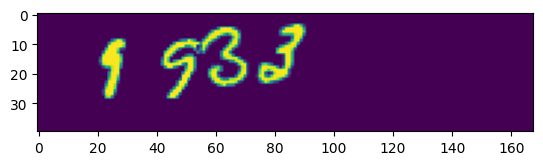

In [5]:
train_val_data = np.concatenate((data0,data1))
test_data = data2
train_val_labels = np.concatenate((lab0,lab1))
test_labels = lab2

t = np.random.randint(10000,20000)
print(train_val_labels[t])
plt.imshow(train_val_data[t])

In [6]:
def one_hot_encoding(num):
    ## maximum possible sum of a 4 digit number is 36
    y = th.zeros(37)
    y[num]=1
    return y

class DigitSumDataset(Dataset):
    def __init__(self,images,sums):
        self.images =images/255
        self.sums = sums
    def __len__(self):
        return(len(self.sums))
    def __getitem__(self,idx):
        img = self.images[idx] 
        # img = img - np.mean(img) ## mean scaling it.
        return(th.tensor(img).reshape(1,40,168).float(),one_hot_encoding(self.sums[idx]))

In [7]:
class low_intensity_gaussian(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean   
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

perturb = transforms.Compose([
    transforms.ToTensor(),
    low_intensity_gaussian(mean=0., std=0.005),  # Low-intensity noise
    transforms.Normalize((0.1307,), (0.3081,))
])


rotate = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.ToTensor()]
)

flip = transforms.Compose([
     transforms.ToPILImage(),
     transforms.RandomHorizontalFlip(),
    transforms.ToTensor()]
)

def return_augmented_imgset(img):
    rotated = rotate(img)
    flipped = flip(img)
    perturbed = perturb(img)
    return(rotated,flipped,perturbed)
    
    

In [8]:
train_img, val_img, train_labels, val_labels = train_test_split(
    train_val_data, 
    train_val_labels, 
    test_size=0.2,  # or train_size=0.8
)

In [9]:
TrS = DigitSumDataset(train_img,train_labels)
VaS  = DigitSumDataset(val_img,val_labels)
TeS = DigitSumDataset(test_data,test_labels)
TrainSet = DataLoader(TrS,batch_size=32)
ValSet = DataLoader(VaS,batch_size=32)
TestSet = DataLoader(TeS,batch_size=32)

In [12]:
## Each Image is 1,40*168

## output must be a single value
from torch.nn import functional as F

    
class BaselineCNN(nn.Module):
    ### 40 *168 image that should be made into a 36 valued tensor
    def __init__(self,inp_channels):
        super(BaselineCNN,self).__init__()
        self.convblock =nn.Sequential(nn.Conv2d(in_channels = inp_channels,
                                                out_channels = 16, kernel_size = (3,3)),
                                       ## current shape: 38,166,16
                                       nn.MaxPool2d(2),
                                       ##current shape: 19,88,16
                                       nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(5,5)),
                                       ## current shape : 15,84,4
                                       nn.MaxPool2d(3),
                                      #current shape : 5,26,32
                                       nn.Conv2d(in_channels=32,out_channels=16,kernel_size=1),
                                      nn.Conv2d(in_channels=16,out_channels=8,kernel_size=2),
                                      )
        ## now our image has 20*28 = 560 dimensions, we pass it through two fc layers
        self.fc_layer = nn.Sequential(
            nn.Linear(800,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Linear(64,1),
        )
    def forward(self,x):
        convolved = self.convblock(x)
        output = self.fc_layer(convolved.view(-1,800))
        return output

test_inp = th.randn(size=(5,1,40,168))
testmod = BaselineCNN(1)
with th.no_grad():
    print(testmod(test_inp).shape)
    print(testmod(test_inp).sum(dim=1))
    print(testmod(test_inp))
        
        
        
    
    

torch.Size([5, 37])
tensor([-0.0224, -0.0090, -0.0214, -0.0339, -0.0308])
tensor([[-3.8152e-02,  7.9476e-02, -4.2221e-02, -1.1894e-02,  4.7542e-02,
         -2.6420e-02,  8.8224e-02,  8.7605e-02,  3.4216e-02, -7.4050e-02,
          1.7287e-02,  5.4371e-02, -1.3487e-04,  6.5799e-02,  1.1675e-01,
          7.7470e-02, -1.0498e-01, -9.6776e-02,  6.7008e-02, -7.9392e-02,
         -1.3831e-01, -9.8394e-02, -3.8206e-02, -6.5755e-02,  7.4071e-02,
         -2.9406e-02, -7.4204e-02,  4.5187e-02, -6.7145e-02,  1.0921e-01,
         -7.5293e-04, -3.6644e-02,  3.5540e-02, -6.3068e-02,  9.9853e-04,
          4.8530e-02,  1.4218e-02],
        [-3.6698e-02,  7.9550e-02, -4.0161e-02, -8.9654e-03,  4.7893e-02,
         -2.7606e-02,  8.9322e-02,  8.7620e-02,  3.4934e-02, -7.3251e-02,
          1.5847e-02,  5.4976e-02, -1.9615e-03,  6.7821e-02,  1.1718e-01,
          7.8880e-02, -1.0243e-01, -9.3868e-02,  6.5953e-02, -7.7532e-02,
         -1.3582e-01, -9.9712e-02, -3.6740e-02, -6.7232e-02,  7.3735e-02,
  

In [13]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

Training without augmentation

Epoch 2, Loss: 3.0767:  10%|█         | 502/5000 [00:49<1:02:07,  1.21it/s]

Epoch 1: Train Loss 3.2045, Val Accuracy 0.0693


Epoch 3, Loss: 3.0564:  20%|██        | 1002/5000 [01:39<1:09:38,  1.05s/it]

Epoch 2: Train Loss 3.1789, Val Accuracy 0.0658


Epoch 4, Loss: 3.0400:  30%|███       | 1502/5000 [02:28<48:00,  1.21it/s]  

Epoch 3: Train Loss 3.1699, Val Accuracy 0.0683


Epoch 5, Loss: 2.9524:  40%|████      | 2002/5000 [03:19<42:46,  1.17it/s]

Epoch 4: Train Loss 3.0629, Val Accuracy 0.0843


Epoch 6, Loss: 2.7693:  50%|█████     | 2502/5000 [04:10<35:06,  1.19it/s]

Epoch 5: Train Loss 2.8113, Val Accuracy 0.1037


Epoch 7, Loss: 2.6560:  60%|██████    | 3002/5000 [05:01<28:00,  1.19it/s]

Epoch 6: Train Loss 2.6465, Val Accuracy 0.0955


Epoch 8, Loss: 2.5031:  70%|███████   | 3502/5000 [05:51<20:39,  1.21it/s]

Epoch 7: Train Loss 2.4976, Val Accuracy 0.1092


Epoch 9, Loss: 2.3272:  80%|████████  | 4002/5000 [06:41<13:33,  1.23it/s]

Epoch 8: Train Loss 2.3648, Val Accuracy 0.1082


Epoch 10, Loss: 2.1654:  90%|█████████ | 4501/5000 [07:29<00:42, 11.78it/s]

Epoch 9: Train Loss 2.2455, Val Accuracy 0.1030


Epoch 10, Loss: 2.0473: 100%|██████████| 5000/5000 [08:18<00:00, 10.02it/s]

Epoch 10: Train Loss 2.0590, Val Accuracy 0.0905


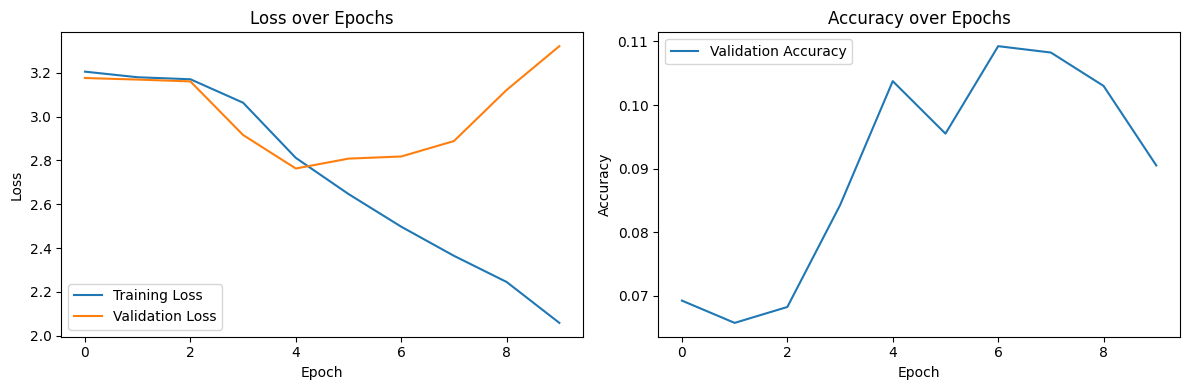

In [14]:
import torch as th
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize lists to track metrics
train_losses = []
val_accuracies = []
val_losses = []

num_epochs = 10
model = BaselineCNN(1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model.parameters(), lr=0.001)

with tqdm(total=num_epochs * len(TrainSet)) as pbar:
    for epoch in range(num_epochs):
        model.train()
        epoch_train_losses = []
        
        # Training phase
        for images, sums in TrainSet:
            optimizer.zero_grad()
            output = model(images.to(device))
            loss = criterion(output, sums.to(device))
            loss.backward()
            optimizer.step()
            
            epoch_train_losses.append(loss.item())
            pbar.update(1)
            pbar.set_description(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
        
        avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
        train_losses.append(avg_train_loss)
        
        model.eval()
        epoch_val_accuracies = []
        epoch_val_losses = []
        
        with th.no_grad():
            for images, sums in ValSet:
                output = model(images.to(device))
                loss = criterion(output, sums.to(device))
                pred = th.argmax(output.to("cpu"), dim=1)
                true_sums = th.argmax(sums,dim=1) 
                accuracy = (pred == true_sums).float().mean().item()
                
                epoch_val_accuracies.append(accuracy)
                epoch_val_losses.append(loss.item())
        
        # Average validation metrics
        avg_val_accuracy = sum(epoch_val_accuracies) / len(epoch_val_accuracies)
        avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
        
        val_accuracies.append(avg_val_accuracy)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.4f}, Val Accuracy {avg_val_accuracy:.4f}")

# Plotting
plt.figure(figsize=(12,4))

# Training Loss Plot
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy Plot
plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
def plot_batch(img_batch):
    # Calculate grid dimensions
    n = len(img_batch)
    nrows = int(np.ceil(np.sqrt(n)))
    ncols = int(np.ceil(n / nrows))
    
    # Create subplot grid
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 10))
    axes = axes.flatten() if n > 1 else [axes]
    
    # Plot each image
    for i, img in enumerate(img_batch):
        if i < len(axes):
            axes[i].imshow(img.permute(1, 2, 0).numpy())
            axes[i].axis('off')
    
    # Remove extra subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


tensor([[-42.2269, -42.5794, -32.5916,  ..., -14.4654, -26.8123, -18.4896],
        [-32.9322, -25.1139, -17.7533,  ..., -20.7090, -24.7221, -20.1760],
        [-26.9669, -11.7159,  -8.4579,  ..., -25.1245, -23.6727, -22.8043],
        ...,
        [-24.6116, -25.7203, -19.4086,  ...,  -5.0160, -14.7717,  -8.6818],
        [-27.6418, -11.0354,  -6.3074,  ..., -23.6624, -23.9859, -21.7983],
        [-23.6405, -25.0807, -17.6433,  ...,  -7.6221, -14.0955,  -9.4098]],
       grad_fn=<AddmmBackward0>)
tensor([15, 14, 12, 14, 20, 21, 25, 26, 23, 21, 25, 16, 25, 20, 13, 19, 19, 20,
        11, 14, 12, 25, 10, 17, 18, 12, 14, 25, 18, 19, 10, 24])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])
tensor([21, 16, 11, 12, 18, 21, 19, 30, 30, 16, 21, 20, 24, 24,  4, 29, 22, 21,
         9, 21, 16, 25, 20, 16, 21, 13, 18, 15, 16, 24, 11, 20]) torch.Size([32])


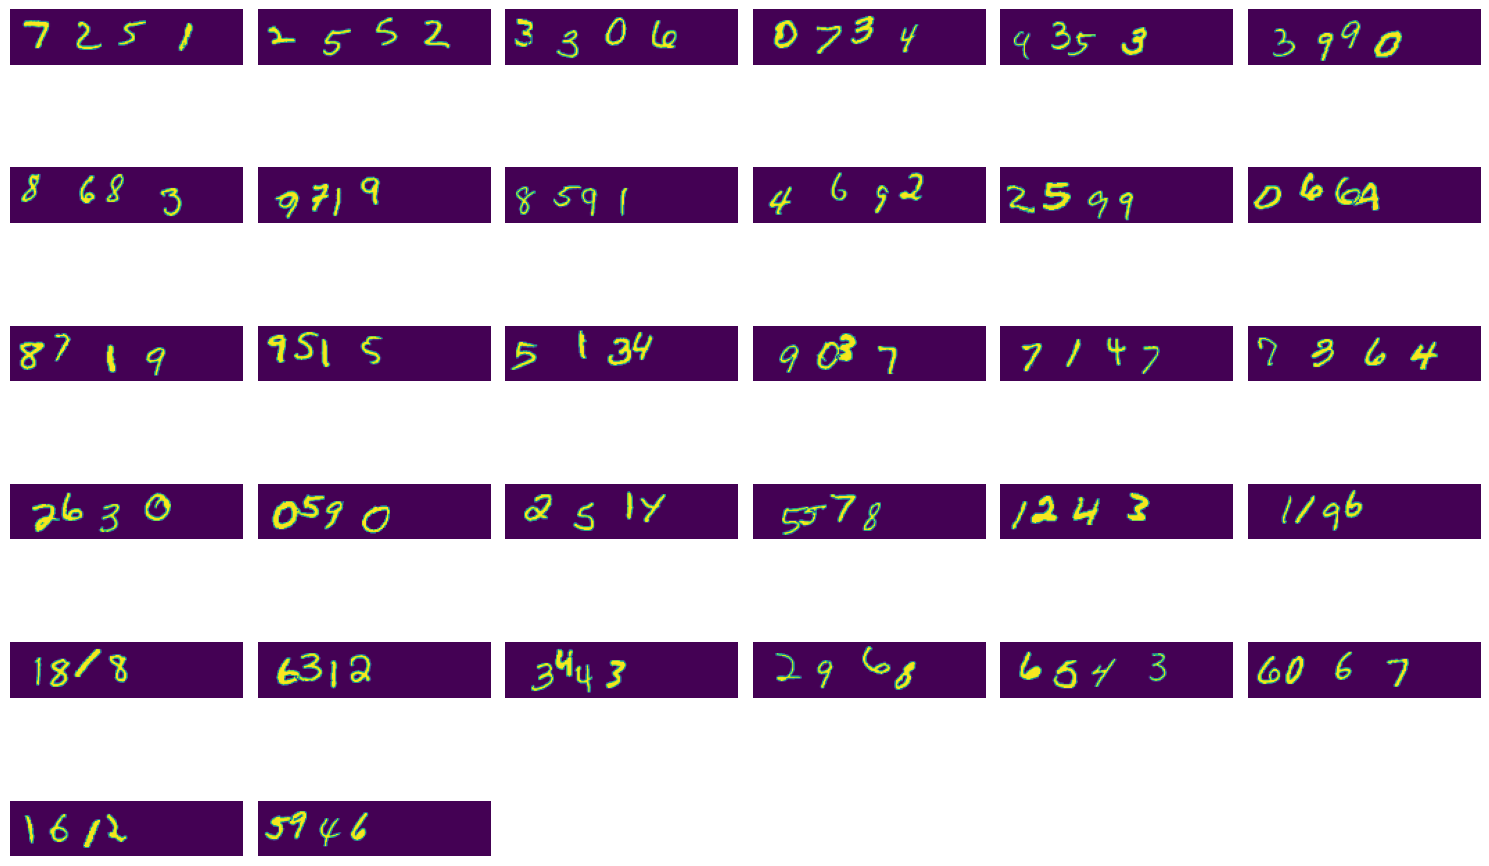

In [ ]:
for images, sums in TestSet:
    output = model(images.to(device))
    print(output)
    loss = criterion(output, sums.to(device))
    pred = th.argmax(output.to("cpu"), dim=1)
    true_sums = th.argmax(sums,dim=1)
    print(th.argmax(sums,dim=1))
    print(sums[0])
    accuracy = (pred == true_sums).float().mean().item()
    print(pred,pred.shape)
    plot_batch(images)
    break
    

    

In [ ]:
print(hi)